# Measuring spectral properties within fixed apertures

While it is more useful to measure global X-ray properties of galaxy clusters within physically motiviated apertures (i.e. using some scale radius such as $R_{500}$), there are cluster studies which have published results measured within fixed apertures. As such, and because it requires essentially no effort on our part to do, we also measure properties within fixed apertures, to provide a point of comparison to those previous studies if it ever becomes necessary.

## Import Statements

In [28]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 80
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sources import GalaxyCluster
from xga.sources import BaseSource
from xga.xspec import single_temp_apec, multi_temp_dem_apec
from xga.exceptions import ModelNotAssociatedError, ParameterNotAssociatedError, NoProductAvailableError

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

%matplotlib inline

## Defining the cosmology

We make use of a concordance LambdaCDM model:

In [2]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in the sample

We need the information from our sample file to declare the XGA ClusterSample further down, primarily the location and redshift, but we also make use of the MCXC estimate of $R_{500}$ to get some idea of the scale of these objects, even if we don't fully trust that measurement:

In [3]:
samp = pd.read_csv('../../sample_files/X-LoVoCCSI.csv')
samp

,LoVoCCSID,Name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,MCXC_Lx500_0.1_2.4
0,1,A2029,227.734300,5.745471,0.0766,1.3344,227.73000,5.720000,227.734300,5.745471,8.726709e+44
1,2,A401,44.740000,13.580000,0.0739,1.2421,44.74000,13.580000,NaN,NaN,6.088643e+44
2,4A,A85North,10.458750,-9.301944,0.0555,1.2103,10.45875,-9.301944,NaN,NaN,5.100085e+44
3,4B,A85South,10.451487,-9.460007,0.0555,1.2103,10.45875,-9.301944,10.451487,-9.460007,5.100085e+44
4,5,A3667,303.157313,-56.845978,0.0556,1.1990,303.13000,-56.830000,303.157313,-56.845978,4.871933e+44
...,...,...,...,...,...,...,...,...,...,...,...
62,121,A3128,52.466189,-52.580728,0.0624,0.8831,52.50000,-52.600000,52.466189,-52.580728,1.101682e+44
63,122,A1023,157.000000,-6.800000,0.1176,0.8553,157.00000,-6.800000,NaN,NaN,1.095941e+44
64,123,A3528,193.670000,-29.220000,0.0544,0.8855,193.67000,-29.220000,NaN,NaN,1.093054e+44
65,131,A761,137.651250,-10.581111,0.0916,0.8627,137.65125,-10.581111,NaN,NaN,1.063423e+44


## Setting up an XGA ClusterSample

We set up an XGA ClusterSample object by passing in the information for the entire LoVoCCS sample, as XGA will determine which of the objects actually has XMM data available for itself. We also use the MCXC estimate of $R_{500}$ to 'clean' the observations that have been retrieved for each object, specifying that 10% of the $R_{500}$ region of each cluster must fall on a given observation for that observation to be used; this cleaning threshold is often set higher, but for this population of large, low-redshift, objects we use this smaller fraction to include offset observations of the outskirts. 

In [4]:
ra = samp['start_ra'].values
dec = samp['start_dec'].values
z = samp['MCXC_Redshift'].values
r500 = Quantity(samp['MCXC_R500'].values, 'Mpc')
name = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x)).values

srcs = ClusterSample(ra, dec, z, name, r500=Quantity(500, 'kpc'), clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.9, 
                     use_peak=False, load_fits=True)

Generating products of type(s) expmap: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


This dictionary shows the names of those clusters which are not included in the ClusterSample because they lack data:

In [5]:
srcs.failed_reasons

{'LoVoCCS-55': 'NoMatch',
 'LoVoCCS-108': 'NoMatch',
 'LoVoCCS-122': 'NoMatch',
 'LoVoCCS-33': 'Failed ObsClean',
 'LoVoCCS-41C': 'Failed ObsClean'}

In [6]:
srcs.info()


-----------------------------------------------------
Number of Sources - 62
Redshift Information - True
Sources with ≥1 detection - 60 [97%]
-----------------------------------------------------



## Setting up the dataframe to store results

In [7]:
ap_rads = [300, 500, 1000]

### Single-temperature absorbed APEC

In [8]:
cols = ['name'] + [ct.format(ar) for ar in ap_rads for ct in ['Tx_{}kpc', 'Tx_{}kpc-', 'Tx_{}kpc+', 
                                                              'met_{}kpc', 'met_{}kpc-', 'met_{}kpc+', 
                                                              'Lx52_{}kpc', 'Lx52_{}kpc-', 'Lx52_{}kpc+', 
                                                              'Lxbol_{}kpc', 'Lxbol_{}kpc-', 'Lxbol_{}kpc+']]
apec_res = pd.DataFrame(columns=cols)
apec_res['name'] = srcs.names

### Multi-temperature absorbed APEC

In [9]:
cols = ['name'] + [ct.format(ar) for ar in ap_rads for ct in ['Tmax_{}kpc', 'Tmax_{}kpc-', 'Tmax_{}kpc+',
                                                              'beta_{}kpc', 'beta_{}kpc-', 'beta_{}kpc+',
                                                              'invsl_{}kpc', 'invsl_{}kpc-', 'invsl_{}kpc+',
                                                              'met_{}kpc', 'met_{}kpc-', 'met_{}kpc+', 
                                                              'Lx52_{}kpc', 'Lx52_{}kpc-', 'Lx52_{}kpc+', 
                                                              'Lxbol_{}kpc', 'Lxbol_{}kpc-', 'Lxbol_{}kpc+']]
wdem_res = pd.DataFrame(columns=cols)
wdem_res['name'] = srcs.names

## Generating and fitting spectra within fixed apertures

We use XGA to generate spectra within different fixed apertures, and then we fit two models to them to extract temperature, abundance, and luminosity information. The first model is a standard absorbed APEC plasma model, and the second is an absorbed multi-temperature APEC model (wdem):

### $R_{\rm{out}}=300\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{inn}}=1000\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{out}}=1500\:\rm{kpc}$

<span style="color:red">This is temporary, XGA will support both setting the background annulus at spectrum generation time, **and** entirely different background methods very soon</span>

In [10]:
for src in srcs:
    src._back_inn_factor = 3.33
    src._back_out_factor = 5

<span style="color:red">Also temporary - need to disassociate observations that cause spectrum generation problems - this will be handled in a more sophisticated way soon</span>

In [11]:
# errors = """[[SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440601_mos1_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440601_mos1_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos1."), SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440601_mos2_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440601_mos2_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos2."), SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440601-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440601_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440601_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-pn."), SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440101_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440101_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440101-pn.")], [SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-22800 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-22800 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =22678.17028, max =21038.17028 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =22678.17028, max =21008.17028 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =-21000, max =-22440 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =-21000, max =-22450 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn."), SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190201_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190201_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos1."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190101_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190101_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos1."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112260201_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112260201_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos1."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190301_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190301_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos1."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112260201_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112260201_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos2."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190301_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190301_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos2."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190201_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190201_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos2."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190101_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190101_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos2."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0112260201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112260201_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112260201_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-pn."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190301_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190301_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-pn."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190101_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190101_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-pn."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190201_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190201_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-pn."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0112260401-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112260401_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260401-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112260401_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260401-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0205190201_mos2_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0205190201_mos2_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos2."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0205190201_mos1_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0205190201_mos1_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos1."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0744412001-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412001_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412001_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-pn."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0205190201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0205190201_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0205190201_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-pn."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0205190101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0205190101_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0205190101_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190101-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.0773046479816188_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.0773046479816188_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-21600 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-21630 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =21700.78381, max =21020.78381 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =21700.78381, max =21000.78381 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =21483.75653, max =21003.75653 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =21483.75653, max =21003.75653 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.')], [SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-27520 ) is invalid.- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-27520 ) is invalid.- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError(' raised by  - - LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.07903740627438989_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.07903740627438989_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0744930201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744930201_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0744930201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744930201_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0744930201-pn."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0601980301_mos2_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0601980301_mos2_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos2."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0601980301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0601980301_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0601980301_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-pn."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0601980301_mos1_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0601980301_mos1_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos1."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0601980101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0601980101_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0601980101_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980101-pn."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0651590201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0651590201_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0651590201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0651590201_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0651590201-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-22 is the associated source, the specific data used is 0744410701-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744410701_pn_LoVoCCS-22_ra258.1966667_dec64.06138889_ri0.0_ro0.05463412948342903_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-22 is the associated source, the specific data used is 0744410701-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744410701_pn_LoVoCCS-22_ra258.1966667_dec64.06138889_ri0.0_ro0.05463412948342903_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-22 is the associated source, the specific data used is 0744410701-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-22000 ) is invalid.- LoVoCCS-22 is the associated source, the specific data used is 0744410501-pn.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-22000 ) is invalid.- LoVoCCS-22 is the associated source, the specific data used is 0744410501-pn.'), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =21816.72875, max =21016.72875 ) is invalid.- LoVoCCS-22 is the associated source, the specific data used is 0744410501-mos2.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =21816.72875, max =21006.72875 ) is invalid.- LoVoCCS-22 is the associated source, the specific data used is 0744410501-mos2.')], [SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =21558.08867, max =21038.08867 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-pn.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =21558.08867, max =21008.08867 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-pn.'), SASGenerationError(' raised by  - - LoVoCCS-26 is the associated source, the specific data used is 0744411501-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411501_pn_LoVoCCS-26_ra55.72458333_dec-53.63527778_ri0.0_ro0.07301944895499086_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-26 is the associated source, the specific data used is 0744411501-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411501_pn_LoVoCCS-26_ra55.72458333_dec-53.63527778_ri0.0_ro0.07301944895499086_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-26 is the associated source, the specific data used is 0744411501-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =21266.9145, max =21026.9145 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-mos1.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =21266.9145, max =21006.9145 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-mos1.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =-21000, max =-21440 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-mos2.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =-21000, max =-21470 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-mos2.')], [SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413101_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413101_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413101-pn."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413301_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413301_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413301-pn."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413401-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413401_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413401_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-22760 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-mos1.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-22760 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-mos1.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =-21000, max =-22400 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-pn.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =-21000, max =-22410 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-pn.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =22631.50643, max =21031.50643 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-mos2.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =22631.50643, max =21001.50643 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-mos2.')], [SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.1391858441604247_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.1391858441604247_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn."), SASGenerationError(' raised by  - - LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.1391858441604247_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.1391858441604247_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-47 is the associated source, the specific data used is 0744412901-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412901_pn_LoVoCCS-47_ra194.2904167_dec-17.40027778_ri0.0_ro0.0898303620464355_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-47 is the associated source, the specific data used is 0744412901-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412901_pn_LoVoCCS-47_ra194.2904167_dec-17.40027778_ri0.0_ro0.0898303620464355_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-47 is the associated source, the specific data used is 0744412901-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =21180.73978, max =21020.73978 ) is invalid.- LoVoCCS-47 is the associated source, the specific data used is 0744412701-mos2.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =21180.73978, max =21000.73978 ) is invalid.- LoVoCCS-47 is the associated source, the specific data used is 0744412701-mos2.'), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-21280 ) is invalid.- LoVoCCS-47 is the associated source, the specific data used is 0744412701-pn.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-21280 ) is invalid.- LoVoCCS-47 is the associated source, the specific data used is 0744412701-pn.')], [SASGenerationError(' raised by  - - LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0674491301_mos1_LoVoCCS-63_ra325.9929167_dec-56.62638889_ri0.0_ro0.0537330498341645_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0674491301_mos1_LoVoCCS-63_ra325.9929167_dec-56.62638889_ri0.0_ro0.0537330498341645_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos1."), SASGenerationError(' raised by  - - LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0674491301_mos2_LoVoCCS-63_ra325.9929167_dec-56.62638889_ri0.0_ro0.0537330498341645_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0674491301_mos2_LoVoCCS-63_ra325.9929167_dec-56.62638889_ri0.0_ro0.0537330498341645_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos2.")], [SASGenerationError(' raised by  - - LoVoCCS-75 is the associated source, the specific data used is 0783380152-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0783380152_pn_LoVoCCS-75_ra348.25375_dec-21.63194444_ri0.0_ro0.05111110125393099_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-75 is the associated source, the specific data used is 0783380152-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0783380152_pn_LoVoCCS-75_ra348.25375_dec-21.63194444_ri0.0_ro0.05111110125393099_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-75 is the associated source, the specific data used is 0783380152-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0861150301_mos2_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0861150301_mos2_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos2."), SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0861150301_mos1_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0861150301_mos1_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos1."), SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0861150301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0861150301_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0861150301_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-pn.")]]"""

# to_dis = {}
# for err in errors.split('SASGenerationError('):
#     name = err.split(' is the associated source,')[0].split('- ')[-1]
    
#     if 'LoVoCCS' in name:
#         if name not in to_dis:
#             to_dis[name] = {}
#         obs_id, inst = err.split('the specific data used is ')[-1].split(".")[0].split('-')
#         if obs_id in to_dis[name]:
#             to_dis[name][obs_id].append(inst)
#         else:
#             to_dis[name][obs_id] = [inst]

# for name in to_dis:
#     for oi in to_dis[name]:
#         to_dis[name][oi] = list(set(to_dis[name][oi]))
#     srcs[name].disassociate_obs(to_dis[name])
# to_dis

#### Single-temperature absorbed APEC model

In [12]:
single_temp_apec(srcs, Quantity(300, 'kpc'), freeze_met=False, one_rmf=False, timeout=timeout)

Running XSPEC Fits: 100%|██████████| 22/22 [07:49<00:00, 21.34s/it]


This is a quick way to check how many successful fits with this model to this aperture's spectra there were:

In [13]:
print(len(np.where(~np.isnan(srcs.Tx(Quantity(300, 'kpc'), quality_checks=False)[:, 0]))[0]))

53


Here we implement a very inelegant way of storing the properties measured using this model for this aperture in the Pandas dataframes set up earlier in the notebook, those will then be saved to disk:

In [14]:
for src in srcs:
    rel_res_ind = np.where(apec_res['name'].values == src.name)[0][0]
    try:
        txs = src.get_temperature(Quantity(300, 'kpc'))
        apec_res.loc[rel_res_ind, ['Tx_300kpc', 'Tx_300kpc-', 'Tx_300kpc+']] = txs.value.round(3)
        
        mets = src.get_results(Quantity(300, 'kpc'), par='Abundanc')
        apec_res.loc[rel_res_ind, ['met_300kpc', 'met_300kpc-', 'met_300kpc+']] = mets.round(3)
        
        lx52s = src.get_luminosities(Quantity(300, 'kpc'), lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lx52_300kpc', 'Lx52_300kpc-', 'Lx52_300kpc+']] = lx52s.to('10^44 erg/s').value.round(3)
        
        lxbols = src.get_luminosities(Quantity(300, 'kpc'), lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lxbol_300kpc', 'Lxbol_300kpc-', 'Lxbol_300kpc+']] = lxbols.to('10^44 erg/s').value.round(3)
    except ModelNotAssociatedError:
        pass

#### Multi-temperature absorbed APEC model

In [15]:
multi_temp_dem_apec(srcs, Quantity(300, 'kpc'), start_max_temp=Quantity(10, 'keV'), freeze_met=False, one_rmf=False, 
                    timeout=Quantity(2, 'hr'))

Running XSPEC Fits: 100%|██████████| 61/61 [2:00:06<00:00, 118.14s/it]  


In [16]:
for src in srcs:
    rel_res_ind = np.where(wdem_res['name'].values == src.name)[0][0]
    try:
        mtxs = src.get_results(Quantity(300, 'kpc'), 'constant*tbabs*wdem', par='Tmax')
        wdem_res.loc[rel_res_ind, ['Tmax_300kpc', 'Tmax_300kpc-', 'Tmax_300kpc+']] = mtxs.round(3)
        
        betas = src.get_results(Quantity(300, 'kpc'), 'constant*tbabs*wdem', par='beta')
        wdem_res.loc[rel_res_ind, ['beta_300kpc', 'beta_300kpc-', 'beta_300kpc+']] = betas.round(3)
        
        inv_sls = src.get_results(Quantity(300, 'kpc'), 'constant*tbabs*wdem', par='inv_slope')
        wdem_res.loc[rel_res_ind, ['invsl_300kpc', 'invsl_300kpc-', 'invsl_300kpc+']] = inv_sls.round(3)
        
        mets = src.get_results(Quantity(300, 'kpc'), 'constant*tbabs*wdem', par='abundanc')
        wdem_res.loc[rel_res_ind, ['met_300kpc', 'met_300kpc-', 'met_300kpc+']] = mets.round(3)
        
        lx52s = src.get_luminosities(Quantity(300, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.5, 'keV'), 
                                     hi_en=Quantity(2.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lx52_300kpc', 'Lx52_300kpc-', 'Lx52_300kpc+']] = lx52s.to('10^44 erg/s').value.round(3)
        
        lxbols = src.get_luminosities(Quantity(300, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.01, 'keV'), 
                                      hi_en=Quantity(100.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lxbol_300kpc', 'Lxbol_300kpc-', 'Lxbol_300kpc+']] = lxbols.to('10^44 erg/s').value.round(3)
    except ModelNotAssociatedError:
        pass

### $R_{\rm{out}}=500\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{inn}}=1000\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{out}}=1500\:\rm{kpc}$

<span style="color:red">This is temporary, XGA will support both setting the background annulus at spectrum generation time, **and** entirely different background methods very soon</span>

In [17]:
for src in srcs:
    src._back_inn_factor = 2
    src._back_out_factor = 3

<span style="color:red">Also temporary - need to disassociate observations that cause spectrum generation problems - this will be handled in a more sophisticated way soon</span>

In [18]:
# errors = """[[SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0112240401-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112240401_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.08321455386617013_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0112240401-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112240401_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.08321455386617013_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0112240401-pn."), SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440201_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.08321455386617013_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440201_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.08321455386617013_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440201-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn."), SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412001_mos1_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412001_mos1_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos1."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412001_mos2_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412001_mos2_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos2."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0744412101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412101_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412101_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412101-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.1288410799693647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.1288410799693647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn."), SASGenerationError(' raised by  - - LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn."), SASGenerationError(' raised by  - - LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413101-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413101_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413101-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413101_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413101-mos2."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413401_mos1_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413401_mos1_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos1."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413301_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413301_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413301-mos2."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413401_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413401_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos2.")], [SASGenerationError(' raised by  - - LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.23197640693404115_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.23197640693404115_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.")], [SASGenerationError(' raised by  - - LoVoCCS-47 is the associated source, the specific data used is 0744413001-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413001_pn_LoVoCCS-47_ra194.2904167_dec-17.40027778_ri0.0_ro0.14971727007739252_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-47 is the associated source, the specific data used is 0744413001-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413001_pn_LoVoCCS-47_ra194.2904167_dec-17.40027778_ri0.0_ro0.14971727007739252_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-47 is the associated source, the specific data used is 0744413001-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0201780101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0201780101_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.12905841171762517_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0201780101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0201780101_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.12905841171762517_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0201780101-pn."), SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0030140201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0030140201_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.12905841171762517_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0030140201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0030140201_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.12905841171762517_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0030140201-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0821310101_mos1_LoVoCCS-120_ra193.6725_dec-29.22333333_ri0.0_ro0.13127572042194044_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0821310101_mos1_LoVoCCS-120_ra193.6725_dec-29.22333333_ri0.0_ro0.13127572042194044_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos1."), SASGenerationError(' raised by  - - LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0821310101_mos2_LoVoCCS-120_ra193.6725_dec-29.22333333_ri0.0_ro0.13127572042194044_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0821310101_mos2_LoVoCCS-120_ra193.6725_dec-29.22333333_ri0.0_ro0.13127572042194044_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos2.")]]"""

# to_dis = {}
# for err in errors.split('SASGenerationError('):
#     name = err.split(' is the associated source,')[0].split('- ')[-1]
    
#     if 'LoVoCCS' in name:
#         if name not in to_dis:
#             to_dis[name] = {}
#         obs_id, inst = err.split('the specific data used is ')[-1].split(".")[0].split('-')
#         if obs_id in to_dis[name]:
#             to_dis[name][obs_id].append(inst)
#         else:
#             to_dis[name][obs_id] = [inst]

# for name in to_dis:
#     for oi in to_dis[name]:
#         to_dis[name][oi] = list(set(to_dis[name][oi]))
#     srcs[name].disassociate_obs(to_dis[name])
# to_dis

#### Single-temperature absorbed APEC model

In [19]:
single_temp_apec(srcs, Quantity(501, 'kpc'), freeze_met=False, one_rmf=False, timeout=timeout)

Running XSPEC Fits: 100%|██████████| 22/22 [09:32<00:00, 26.00s/it] 


In [20]:
print(len(np.where(~np.isnan(srcs.Tx(Quantity(501, 'kpc'), quality_checks=False)[:, 0]))[0]))

54


In [21]:
for src in srcs:
    rel_res_ind = np.where(apec_res['name'].values == src.name)[0][0]
    try:
        mets = src.get_results(Quantity(501, 'kpc'), par='Abundanc')
        apec_res.loc[rel_res_ind, ['met_500kpc', 'met_500kpc-', 'met_500kpc+']] = mets.round(3)
        
        txs = src.get_temperature(Quantity(501, 'kpc'))
        apec_res.loc[rel_res_ind, ['Tx_500kpc', 'Tx_500kpc-', 'Tx_500kpc+']] = txs.value.round(3)
        
        lx52s = src.get_luminosities(Quantity(501, 'kpc'), lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lx52_500kpc', 'Lx52_500kpc-', 'Lx52_500kpc+']] = lx52s.to('10^44 erg/s').value.round(3)
        
        lxbols = src.get_luminosities(Quantity(501, 'kpc'), lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lxbol_500kpc', 'Lxbol_500kpc-', 'Lxbol_500kpc+']] = lxbols.to('10^44 erg/s').value.round(3)
    except (ModelNotAssociatedError, ParameterNotAssociatedError):
        pass

#### Multi-temperature absorbed-APEC model

In [22]:
multi_temp_dem_apec(srcs, Quantity(501, 'kpc'), start_max_temp=Quantity(10, 'keV'), freeze_met=False, one_rmf=False, 
                    timeout=Quantity(2, 'hr'))

Running XSPEC Fits: 100%|██████████| 62/62 [2:00:06<00:00, 116.24s/it]  


In [23]:
for src in srcs:
    rel_res_ind = np.where(wdem_res['name'].values == src.name)[0][0]
    try:
        mtxs = src.get_results(Quantity(501, 'kpc'), 'constant*tbabs*wdem', par='Tmax')
        wdem_res.loc[rel_res_ind, ['Tmax_500kpc', 'Tmax_500kpc-', 'Tmax_500kpc+']] = mtxs
        
        print(src.name)
        for sp in src.get_spectra(Quantity(501, 'kpc')):
            sp.view()
        
        betas = src.get_results(Quantity(501, 'kpc'), 'constant*tbabs*wdem', par='beta')
        wdem_res.loc[rel_res_ind, ['beta_500kpc', 'beta_500kpc-', 'beta_500kpc+']] = betas
        
        inv_sls = src.get_results(Quantity(501, 'kpc'), 'constant*tbabs*wdem', par='inv_slope')
        wdem_res.loc[rel_res_ind, ['invsl_500kpc', 'invsl_500kpc-', 'invsl_500kpc+']] = inv_sls
        
        mets = src.get_results(Quantity(501, 'kpc'), 'constant*tbabs*wdem', par='abundanc')
        wdem_res.loc[rel_res_ind, ['met_500kpc', 'met_500kpc-', 'met_500kpc+']] = mets
        
        lx52s = src.get_luminosities(Quantity(501, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.5, 'keV'), 
                                     hi_en=Quantity(2.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lx52_500kpc', 'Lx52_500kpc-', 'Lx52_500kpc+']] = lx52s.to('10^44 erg/s').value
        
        lxbols = src.get_luminosities(Quantity(501, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.01, 'keV'), 
                                      hi_en=Quantity(100.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lxbol_500kpc', 'Lxbol_500kpc-', 'Lxbol_500kpc+']] = lxbols.to('10^44 erg/s').value
    except ModelNotAssociatedError:
        pass

### $R_{\rm{out}}=1000\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{inn}}=1050\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{out}}=1500\:\rm{kpc}$

<span style="color:red">This is temporary, XGA will support both setting the background annulus at spectrum generation time, **and** entirely different background methods very soon</span>

In [24]:
for src in srcs:
    src._back_inn_factor = 1.05
    src._back_out_factor = 1.5

<span style="color:red">Also temporary - need to disassociate observations that cause spectrum generation problems - this will be handled in a more sophisticated way soon</span>

In [25]:
# errors = """[[SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.19137752290704207_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.19137752290704207_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.")], [SASGenerationError("/bin/sh: line 1: 50598 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1."), SASGenerationError('/bin/sh: line 1: 50599 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError('/bin/sh: line 1: 50692 Segmentation fault      (core dumped) backscale spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError('/bin/sh: line 1: 51928 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError("/bin/sh: line 1: 50502 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1."), SASGenerationError('/bin/sh: line 1: 50506 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError('/bin/sh: line 1: 50535 Segmentation fault      (core dumped) backscale spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError('/bin/sh: line 1: 51948 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError("/bin/sh: line 1: 50538 Segmentation fault      (core dumped) rmfgen rmfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1."), SASGenerationError('/bin/sh: line 1: 50539 Segmentation fault      (core dumped) arfgen spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError('/bin/sh: line 1: 50569 Segmentation fault      (core dumped) backscale spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError('/bin/sh: line 1: 51954 Segmentation fault      (core dumped) specgroup spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError("/bin/sh: line 1: 50529 Segmentation fault      (core dumped) rmfgen rmfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2."), SASGenerationError('/bin/sh: line 1: 50530 Segmentation fault      (core dumped) arfgen spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError('/bin/sh: line 1: 50556 Segmentation fault      (core dumped) backscale spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError('/bin/sh: line 1: 51971 Segmentation fault      (core dumped) specgroup spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError("/bin/sh: line 1: 50504 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2."), SASGenerationError('/bin/sh: line 1: 50507 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError('/bin/sh: line 1: 50540 Segmentation fault      (core dumped) backscale spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError('/bin/sh: line 1: 52011 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError("/bin/sh: line 1: 50626 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1."), SASGenerationError('/bin/sh: line 1: 50629 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError('/bin/sh: line 1: 50705 Segmentation fault      (core dumped) backscale spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError('/bin/sh: line 1: 52126 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError("/bin/sh: line 1: 50693 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2."), SASGenerationError('/bin/sh: line 1: 50696 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError('/bin/sh: line 1: 50745 Segmentation fault      (core dumped) backscale spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError('/bin/sh: line 1: 52134 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError("/bin/sh: line 1: 50682 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1."), SASGenerationError('/bin/sh: line 1: 50683 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError('/bin/sh: line 1: 50732 Segmentation fault      (core dumped) backscale spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError('/bin/sh: line 1: 52157 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError("/bin/sh: line 1: 50674 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2."), SASGenerationError('/bin/sh: line 1: 50675 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError('/bin/sh: line 1: 50726 Segmentation fault      (core dumped) backscale spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError('/bin/sh: line 1: 52163 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError("/bin/sh: line 1: 50715 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2."), SASGenerationError('/bin/sh: line 1: 50716 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError('/bin/sh: line 1: 50762 Segmentation fault      (core dumped) backscale spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError('/bin/sh: line 1: 52188 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError("/bin/sh: line 1: 51530 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1."), SASGenerationError('/bin/sh: line 1: 51536 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError('/bin/sh: line 1: 51600 Segmentation fault      (core dumped) backscale spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError('/bin/sh: line 1: 53404 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError("/bin/sh: line 1: 51561 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2."), SASGenerationError('/bin/sh: line 1: 51564 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError('/bin/sh: line 1: 51633 Segmentation fault      (core dumped) backscale spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError('/bin/sh: line 1: 53477 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError("/bin/sh: line 1: 51800 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1."), SASGenerationError('/bin/sh: line 1: 51803 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError('/bin/sh: line 1: 51865 Segmentation fault      (core dumped) backscale spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError('/bin/sh: line 1: 54631 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError("/bin/sh: line 1: 51857 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2."), SASGenerationError('/bin/sh: line 1: 51858 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError('/bin/sh: line 1: 52012 Segmentation fault      (core dumped) backscale spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError('/bin/sh: line 1: 54763 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError("/bin/sh: line 1: 52019 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1."), SASGenerationError('/bin/sh: line 1: 52020 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError('/bin/sh: line 1: 52152 Segmentation fault      (core dumped) backscale spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError('/bin/sh: line 1: 54839 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError("/bin/sh: line 1: 52000 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2."), SASGenerationError('/bin/sh: line 1: 52001 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError('/bin/sh: line 1: 52154 Segmentation fault      (core dumped) backscale spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError('/bin/sh: line 1: 54847 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError("/bin/sh: line 1: 51790 Segmentation fault      (core dumped) rmfgen rmfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn."), SASGenerationError('/bin/sh: line 1: 51792 Segmentation fault      (core dumped) arfgen spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError('/bin/sh: line 1: 52112 Segmentation fault      (core dumped) backscale spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError('/bin/sh: line 1: 55104 Segmentation fault      (core dumped) specgroup spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError("/bin/sh: line 1: 51979 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn."), SASGenerationError('/bin/sh: line 1: 51980 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError('/bin/sh: line 1: 52278 Segmentation fault      (core dumped) backscale spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError('/bin/sh: line 1: 55234 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError("/bin/sh: line 1: 53112 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn."), SASGenerationError('/bin/sh: line 1: 53113 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError('/bin/sh: line 1: 53490 Segmentation fault      (core dumped) backscale spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError('/bin/sh: line 1: 55890 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError("/bin/sh: line 1: 53383 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn."), SASGenerationError('/bin/sh: line 1: 53385 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError('/bin/sh: line 1: 54717 Segmentation fault      (core dumped) backscale spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError('/bin/sh: line 1: 55907 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError("/bin/sh: line 1: 55009 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1."), SASGenerationError('/bin/sh: line 1: 55010 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError('/bin/sh: line 1: 55099 Segmentation fault      (core dumped) backscale spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError('/bin/sh: line 1: 56064 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError("/bin/sh: line 1: 55046 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2."), SASGenerationError('/bin/sh: line 1: 55047 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError('/bin/sh: line 1: 55200 Segmentation fault      (core dumped) backscale spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError('/bin/sh: line 1: 56137 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError("/bin/sh: line 1: 55458 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1."), SASGenerationError('/bin/sh: line 1: 55459 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError('/bin/sh: line 1: 55557 Segmentation fault      (core dumped) backscale spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError('/bin/sh: line 1: 56359 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError("/bin/sh: line 1: 55568 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1."), SASGenerationError('/bin/sh: line 1: 55569 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError('/bin/sh: line 1: 55713 Segmentation fault      (core dumped) backscale spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError('/bin/sh: line 1: 56419 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError("/bin/sh: line 1: 55511 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2."), SASGenerationError('/bin/sh: line 1: 55513 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError('/bin/sh: line 1: 55659 Segmentation fault      (core dumped) backscale spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError('/bin/sh: line 1: 56423 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError("/bin/sh: line 1: 55672 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1."), SASGenerationError('/bin/sh: line 1: 55673 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError('/bin/sh: line 1: 55779 Segmentation fault      (core dumped) backscale spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError('/bin/sh: line 1: 56437 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError("/bin/sh: line 1: 55664 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2."), SASGenerationError('/bin/sh: line 1: 55665 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError('/bin/sh: line 1: 55775 Segmentation fault      (core dumped) backscale spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError('/bin/sh: line 1: 56521 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError("/bin/sh: line 1: 55684 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2."), SASGenerationError('/bin/sh: line 1: 55685 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError('/bin/sh: line 1: 55783 Segmentation fault      (core dumped) backscale spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError('/bin/sh: line 1: 56528 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError("/bin/sh: line 1: 55809 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn."), SASGenerationError('/bin/sh: line 1: 55811 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError('/bin/sh: line 1: 55919 Segmentation fault      (core dumped) backscale spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError('/bin/sh: line 1: 56733 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError("/bin/sh: line 1: 56065 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn."), SASGenerationError('/bin/sh: line 1: 56068 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError('/bin/sh: line 1: 56089 Segmentation fault      (core dumped) backscale spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError('/bin/sh: line 1: 56850 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError("/bin/sh: line 1: 56145 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn."), SASGenerationError('/bin/sh: line 1: 56146 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError('/bin/sh: line 1: 56221 Segmentation fault      (core dumped) backscale spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError('/bin/sh: line 1: 56955 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError("/bin/sh: line 1: 56153 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn."), SASGenerationError('/bin/sh: line 1: 56154 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError('/bin/sh: line 1: 56228 Segmentation fault      (core dumped) backscale spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError('/bin/sh: line 1: 56958 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.')], [SASGenerationError("/bin/sh: line 1: 51038 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1."), SASGenerationError('/bin/sh: line 1: 51039 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError('/bin/sh: line 1: 51075 Segmentation fault      (core dumped) backscale spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError('/bin/sh: line 1: 51334 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError("/bin/sh: line 1: 51056 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2."), SASGenerationError('/bin/sh: line 1: 51057 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError('/bin/sh: line 1: 51101 Segmentation fault      (core dumped) backscale spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError('/bin/sh: line 1: 51350 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError("/bin/sh: line 1: 51090 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2."), SASGenerationError('/bin/sh: line 1: 51092 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError('/bin/sh: line 1: 51191 Segmentation fault      (core dumped) backscale spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError('/bin/sh: line 1: 51461 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError("/bin/sh: line 1: 51113 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1."), SASGenerationError('/bin/sh: line 1: 51114 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError('/bin/sh: line 1: 51207 Segmentation fault      (core dumped) backscale spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError('/bin/sh: line 1: 51529 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError("/bin/sh: line 1: 51389 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn."), SASGenerationError('/bin/sh: line 1: 51392 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError('/bin/sh: line 1: 51650 Segmentation fault      (core dumped) backscale spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError('/bin/sh: line 1: 52235 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError("/bin/sh: line 1: 51560 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn."), SASGenerationError('/bin/sh: line 1: 51563 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError('/bin/sh: line 1: 51740 Segmentation fault      (core dumped) backscale spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError('/bin/sh: line 1: 52355 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError("/bin/sh: line 1: 50738 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1."), SASGenerationError('/bin/sh: line 1: 50739 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError('/bin/sh: line 1: 50815 Segmentation fault      (core dumped) backscale spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError('/bin/sh: line 1: 52395 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError("/bin/sh: line 1: 50750 Segmentation fault      (core dumped) rmfgen rmfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2."), SASGenerationError('/bin/sh: line 1: 50752 Segmentation fault      (core dumped) arfgen spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError('/bin/sh: line 1: 50825 Segmentation fault      (core dumped) backscale spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError('/bin/sh: line 1: 52399 Segmentation fault      (core dumped) specgroup spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError("/bin/sh: line 1: 50828 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2."), SASGenerationError('/bin/sh: line 1: 50829 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError('/bin/sh: line 1: 50866 Segmentation fault      (core dumped) backscale spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError('/bin/sh: line 1: 52462 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError("/bin/sh: line 1: 52451 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2."), SASGenerationError('/bin/sh: line 1: 52452 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError('/bin/sh: line 1: 52971 Segmentation fault      (core dumped) backscale spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError('/bin/sh: line 1: 53378 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError("/bin/sh: line 1: 52468 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1."), SASGenerationError('/bin/sh: line 1: 52469 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError('/bin/sh: line 1: 53026 Segmentation fault      (core dumped) backscale spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError('/bin/sh: line 1: 53399 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError("/bin/sh: line 1: 54872 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn."), SASGenerationError('/bin/sh: line 1: 54873 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError('/bin/sh: line 1: 55095 Segmentation fault      (core dumped) backscale spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError('/bin/sh: line 1: 55477 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError("/bin/sh: line 1: 55290 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1."), SASGenerationError('/bin/sh: line 1: 55291 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError('/bin/sh: line 1: 55491 Segmentation fault      (core dumped) backscale spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError('/bin/sh: line 1: 55578 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError("/bin/sh: line 1: 55486 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1."), SASGenerationError('/bin/sh: line 1: 55487 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError('/bin/sh: line 1: 55555 Segmentation fault      (core dumped) backscale spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError('/bin/sh: line 1: 55717 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError("/bin/sh: line 1: 55379 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2."), SASGenerationError('/bin/sh: line 1: 55380 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError('/bin/sh: line 1: 55548 Segmentation fault      (core dumped) backscale spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError('/bin/sh: line 1: 55720 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError("/bin/sh: line 1: 55505 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2."), SASGenerationError('/bin/sh: line 1: 55506 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError('/bin/sh: line 1: 55576 Segmentation fault      (core dumped) backscale spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError('/bin/sh: line 1: 55794 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError("/bin/sh: line 1: 55952 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn."), SASGenerationError('/bin/sh: line 1: 55953 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError('/bin/sh: line 1: 55970 Segmentation fault      (core dumped) backscale spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError('/bin/sh: line 1: 56157 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError("/bin/sh: line 1: 55978 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn."), SASGenerationError('/bin/sh: line 1: 55979 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError('/bin/sh: line 1: 55994 Segmentation fault      (core dumped) backscale spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError('/bin/sh: line 1: 56226 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.')], [SASGenerationError("/bin/sh: line 1: 50519 Segmentation fault      (core dumped) rmfgen rmfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095010901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2."), SASGenerationError('/bin/sh: line 1: 50520 Segmentation fault      (core dumped) arfgen spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095010901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095010901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError('/bin/sh: line 1: 50557 Segmentation fault      (core dumped) backscale spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095010901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError('/bin/sh: line 1: 50760 Segmentation fault      (core dumped) specgroup spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError("/bin/sh: line 1: 50513 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1."), SASGenerationError('/bin/sh: line 1: 50514 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError('/bin/sh: line 1: 50544 Segmentation fault      (core dumped) backscale spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError('/bin/sh: line 1: 50954 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError("/bin/sh: line 1: 50854 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn."), SASGenerationError('/bin/sh: line 1: 50856 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError('/bin/sh: line 1: 50902 Segmentation fault      (core dumped) backscale spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError('/bin/sh: line 1: 51543 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError("/bin/sh: line 1: 51251 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2."), SASGenerationError('/bin/sh: line 1: 51253 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError('/bin/sh: line 1: 51540 Segmentation fault      (core dumped) backscale spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError('/bin/sh: line 1: 51924 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError("/bin/sh: line 1: 51551 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1."), SASGenerationError('/bin/sh: line 1: 51553 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError('/bin/sh: line 1: 51584 Segmentation fault      (core dumped) backscale spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError('/bin/sh: line 1: 52224 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError("/bin/sh: line 1: 52025 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1."), SASGenerationError('/bin/sh: line 1: 52027 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError('/bin/sh: line 1: 52175 Segmentation fault      (core dumped) backscale spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError('/bin/sh: line 1: 52309 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError("/bin/sh: line 1: 52062 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2."), SASGenerationError('/bin/sh: line 1: 52096 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError('/bin/sh: line 1: 52229 Segmentation fault      (core dumped) backscale spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError('/bin/sh: line 1: 52361 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError("/bin/sh: line 1: 51811 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2."), SASGenerationError('/bin/sh: line 1: 51814 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError('/bin/sh: line 1: 51930 Segmentation fault      (core dumped) backscale spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError('/bin/sh: line 1: 52943 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError("/bin/sh: line 1: 53034 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2."), SASGenerationError('/bin/sh: line 1: 53035 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError('/bin/sh: line 1: 53301 Segmentation fault      (core dumped) backscale spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError('/bin/sh: line 1: 53560 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError("/bin/sh: line 1: 53043 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1."), SASGenerationError('/bin/sh: line 1: 53044 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError('/bin/sh: line 1: 53309 Segmentation fault      (core dumped) backscale spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError('/bin/sh: line 1: 54635 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError("/bin/sh: line 1: 53121 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn."), SASGenerationError('/bin/sh: line 1: 53127 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError('/bin/sh: line 1: 53497 Segmentation fault      (core dumped) backscale spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError('/bin/sh: line 1: 54844 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError("/bin/sh: line 1: 53016 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn."), SASGenerationError('/bin/sh: line 1: 53017 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError('/bin/sh: line 1: 53423 Segmentation fault      (core dumped) backscale spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError('/bin/sh: line 1: 55025 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError("/bin/sh: line 1: 55112 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1."), SASGenerationError('/bin/sh: line 1: 55113 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError('/bin/sh: line 1: 55237 Segmentation fault      (core dumped) backscale spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError('/bin/sh: line 1: 55311 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError("/bin/sh: line 1: 55189 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1."), SASGenerationError('/bin/sh: line 1: 55191 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError('/bin/sh: line 1: 55280 Segmentation fault      (core dumped) backscale spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError('/bin/sh: line 1: 55393 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError("/bin/sh: line 1: 55128 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2."), SASGenerationError('/bin/sh: line 1: 55129 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError('/bin/sh: line 1: 55267 Segmentation fault      (core dumped) backscale spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError('/bin/sh: line 1: 55396 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError("/bin/sh: line 1: 55208 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2."), SASGenerationError('/bin/sh: line 1: 55209 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError('/bin/sh: line 1: 55302 Segmentation fault      (core dumped) backscale spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError('/bin/sh: line 1: 55501 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError("/bin/sh: line 1: 55035 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn."), SASGenerationError('/bin/sh: line 1: 55036 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError('/bin/sh: line 1: 55305 Segmentation fault      (core dumped) backscale spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError('/bin/sh: line 1: 55702 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError("/bin/sh: line 1: 55896 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn."), SASGenerationError('/bin/sh: line 1: 55897 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError('/bin/sh: line 1: 55947 Segmentation fault      (core dumped) backscale spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError('/bin/sh: line 1: 56075 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError("/bin/sh: line 1: 55895 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn."), SASGenerationError('/bin/sh: line 1: 55900 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError('/bin/sh: line 1: 55949 Segmentation fault      (core dumped) backscale spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError('/bin/sh: line 1: 56079 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.')], [SASGenerationError("/bin/sh: line 1: 51223 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2."), SASGenerationError('/bin/sh: line 1: 51224 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError('/bin/sh: line 1: 51269 Segmentation fault      (core dumped) backscale spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError('/bin/sh: line 1: 51837 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError("/bin/sh: line 1: 51323 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1."), SASGenerationError('/bin/sh: line 1: 51325 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError('/bin/sh: line 1: 51525 Segmentation fault      (core dumped) backscale spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError('/bin/sh: line 1: 52099 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError("/bin/sh: line 1: 51688 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1."), SASGenerationError('/bin/sh: line 1: 51689 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError('/bin/sh: line 1: 51813 Segmentation fault      (core dumped) backscale spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError('/bin/sh: line 1: 52368 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError("/bin/sh: line 1: 51709 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2."), SASGenerationError('/bin/sh: line 1: 51713 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError('/bin/sh: line 1: 51850 Segmentation fault      (core dumped) backscale spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError('/bin/sh: line 1: 52391 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError("/bin/sh: line 1: 51668 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn."), SASGenerationError('/bin/sh: line 1: 51669 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError('/bin/sh: line 1: 51985 Segmentation fault      (core dumped) backscale spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError('/bin/sh: line 1: 53140 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError("/bin/sh: line 1: 52440 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn."), SASGenerationError('/bin/sh: line 1: 52441 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError('/bin/sh: line 1: 53306 Segmentation fault      (core dumped) backscale spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError('/bin/sh: line 1: 54886 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError("/bin/sh: line 1: 53483 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1."), SASGenerationError('/bin/sh: line 1: 53484 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError('/bin/sh: line 1: 54669 Segmentation fault      (core dumped) backscale spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError('/bin/sh: line 1: 55041 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError("/bin/sh: line 1: 53568 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2."), SASGenerationError('/bin/sh: line 1: 53569 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError('/bin/sh: line 1: 54748 Segmentation fault      (core dumped) backscale spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError('/bin/sh: line 1: 55108 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError("/bin/sh: line 1: 54852 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1."), SASGenerationError('/bin/sh: line 1: 54854 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError('/bin/sh: line 1: 54929 Segmentation fault      (core dumped) backscale spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError('/bin/sh: line 1: 55284 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError("/bin/sh: line 1: 54909 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2."), SASGenerationError('/bin/sh: line 1: 54910 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError('/bin/sh: line 1: 55015 Segmentation fault      (core dumped) backscale spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError('/bin/sh: line 1: 55455 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError("/bin/sh: line 1: 55212 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn."), SASGenerationError('/bin/sh: line 1: 55213 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError('/bin/sh: line 1: 55545 Segmentation fault      (core dumped) backscale spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError('/bin/sh: line 1: 55985 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError("/bin/sh: line 1: 55707 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn."), SASGenerationError('/bin/sh: line 1: 55708 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.'), SASGenerationError('/bin/sh: line 1: 55886 Segmentation fault      (core dumped) backscale spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.'), SASGenerationError('/bin/sh: line 1: 56241 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.')], [SASGenerationError("/bin/sh: line 1: 50521 Segmentation fault      (core dumped) rmfgen rmfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2."), SASGenerationError('/bin/sh: line 1: 50524 Segmentation fault      (core dumped) arfgen spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError('/bin/sh: line 1: 50554 Segmentation fault      (core dumped) backscale spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError('/bin/sh: line 1: 50795 Segmentation fault      (core dumped) specgroup spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError("/bin/sh: line 1: 50548 Segmentation fault      (core dumped) rmfgen rmfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1."), SASGenerationError('/bin/sh: line 1: 50549 Segmentation fault      (core dumped) arfgen spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError('/bin/sh: line 1: 50579 Segmentation fault      (core dumped) backscale spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError('/bin/sh: line 1: 50807 Segmentation fault      (core dumped) specgroup spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError("/bin/sh: line 1: 50889 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1."), SASGenerationError('/bin/sh: line 1: 50891 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError('/bin/sh: line 1: 50969 Segmentation fault      (core dumped) backscale spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError('/bin/sh: line 1: 51078 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError("/bin/sh: line 1: 50869 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2."), SASGenerationError('/bin/sh: line 1: 50870 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError('/bin/sh: line 1: 50962 Segmentation fault      (core dumped) backscale spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError('/bin/sh: line 1: 51104 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError("/bin/sh: line 1: 50998 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1."), SASGenerationError('/bin/sh: line 1: 51001 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError('/bin/sh: line 1: 51048 Segmentation fault      (core dumped) backscale spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError('/bin/sh: line 1: 51245 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError("/bin/sh: line 1: 51006 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2."), SASGenerationError('/bin/sh: line 1: 51007 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError('/bin/sh: line 1: 51052 Segmentation fault      (core dumped) backscale spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError('/bin/sh: line 1: 51263 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError("/bin/sh: line 1: 51062 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1."), SASGenerationError('/bin/sh: line 1: 51063 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError('/bin/sh: line 1: 51091 Segmentation fault      (core dumped) backscale spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError('/bin/sh: line 1: 51293 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError("/bin/sh: line 1: 51128 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2."), SASGenerationError('/bin/sh: line 1: 51130 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError('/bin/sh: line 1: 51211 Segmentation fault      (core dumped) backscale spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError('/bin/sh: line 1: 51391 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError("/bin/sh: line 1: 51217 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1."), SASGenerationError('/bin/sh: line 1: 51218 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError('/bin/sh: line 1: 51257 Segmentation fault      (core dumped) backscale spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError('/bin/sh: line 1: 51483 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError("/bin/sh: line 1: 51378 Segmentation fault      (core dumped) rmfgen rmfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1."), SASGenerationError('/bin/sh: line 1: 51379 Segmentation fault      (core dumped) arfgen spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError('/bin/sh: line 1: 51386 Segmentation fault      (core dumped) backscale spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError('/bin/sh: line 1: 51603 Segmentation fault      (core dumped) specgroup spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError("/bin/sh: line 1: 51033 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn."), SASGenerationError('/bin/sh: line 1: 51034 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError('/bin/sh: line 1: 51123 Segmentation fault      (core dumped) backscale spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError('/bin/sh: line 1: 51635 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError("/bin/sh: line 1: 50989 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn."), SASGenerationError('/bin/sh: line 1: 50991 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError('/bin/sh: line 1: 51111 Segmentation fault      (core dumped) backscale spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError('/bin/sh: line 1: 51642 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError("/bin/sh: line 1: 51456 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2."), SASGenerationError('/bin/sh: line 1: 51457 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError('/bin/sh: line 1: 51562 Segmentation fault      (core dumped) backscale spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError('/bin/sh: line 1: 51700 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError("/bin/sh: line 1: 51195 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn."), SASGenerationError('/bin/sh: line 1: 51198 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError('/bin/sh: line 1: 51243 Segmentation fault      (core dumped) backscale spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError('/bin/sh: line 1: 51812 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError("/bin/sh: line 1: 51317 Segmentation fault      (core dumped) rmfgen rmfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn."), SASGenerationError('/bin/sh: line 1: 51318 Segmentation fault      (core dumped) arfgen spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError('/bin/sh: line 1: 51345 Segmentation fault      (core dumped) backscale spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError('/bin/sh: line 1: 51914 Segmentation fault      (core dumped) specgroup spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError("/bin/sh: line 1: 51674 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1."), SASGenerationError('/bin/sh: line 1: 51675 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError('/bin/sh: line 1: 51710 Segmentation fault      (core dumped) backscale spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError('/bin/sh: line 1: 51942 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError("/bin/sh: line 1: 51234 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn."), SASGenerationError('/bin/sh: line 1: 51237 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError('/bin/sh: line 1: 51435 Segmentation fault      (core dumped) backscale spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError('/bin/sh: line 1: 51961 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError("/bin/sh: line 1: 51684 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2."), SASGenerationError('/bin/sh: line 1: 51685 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError('/bin/sh: line 1: 51796 Segmentation fault      (core dumped) backscale spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError('/bin/sh: line 1: 51986 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError("/bin/sh: line 1: 51742 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1."), SASGenerationError('/bin/sh: line 1: 51750 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError('/bin/sh: line 1: 51849 Segmentation fault      (core dumped) backscale spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError('/bin/sh: line 1: 52109 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError("/bin/sh: line 1: 51732 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2."), SASGenerationError('/bin/sh: line 1: 51733 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError('/bin/sh: line 1: 51843 Segmentation fault      (core dumped) backscale spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError('/bin/sh: line 1: 52117 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError("/bin/sh: line 1: 51984 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1."), SASGenerationError('/bin/sh: line 1: 51987 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError('/bin/sh: line 1: 52007 Segmentation fault      (core dumped) backscale spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError('/bin/sh: line 1: 52191 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError("/bin/sh: line 1: 51693 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn."), SASGenerationError('/bin/sh: line 1: 51694 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError('/bin/sh: line 1: 51801 Segmentation fault      (core dumped) backscale spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError('/bin/sh: line 1: 52271 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError("/bin/sh: line 1: 52173 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn."), SASGenerationError('/bin/sh: line 1: 52174 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError('/bin/sh: line 1: 52218 Segmentation fault      (core dumped) backscale spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError('/bin/sh: line 1: 52654 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError("/bin/sh: line 1: 52383 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1."), SASGenerationError('/bin/sh: line 1: 52386 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError('/bin/sh: line 1: 52486 Segmentation fault      (core dumped) backscale spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError('/bin/sh: line 1: 53116 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError("/bin/sh: line 1: 52414 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2."), SASGenerationError('/bin/sh: line 1: 52415 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError('/bin/sh: line 1: 52519 Segmentation fault      (core dumped) backscale spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError('/bin/sh: line 1: 53293 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError("/bin/sh: line 1: 52037 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1."), SASGenerationError('/bin/sh: line 1: 52038 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError('/bin/sh: line 1: 52148 Segmentation fault      (core dumped) backscale spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError('/bin/sh: line 1: 53468 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError("/bin/sh: line 1: 52513 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn."), SASGenerationError('/bin/sh: line 1: 52514 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError('/bin/sh: line 1: 53109 Segmentation fault      (core dumped) backscale spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError('/bin/sh: line 1: 53482 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError("/bin/sh: line 1: 53311 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2."), SASGenerationError('/bin/sh: line 1: 53313 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError('/bin/sh: line 1: 53461 Segmentation fault      (core dumped) backscale spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError('/bin/sh: line 1: 54645 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError("/bin/sh: line 1: 52474 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn."), SASGenerationError('/bin/sh: line 1: 52476 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError('/bin/sh: line 1: 53382 Segmentation fault      (core dumped) backscale spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError('/bin/sh: line 1: 54723 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError("/bin/sh: line 1: 53391 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1."), SASGenerationError('/bin/sh: line 1: 53392 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError('/bin/sh: line 1: 53837 Segmentation fault      (core dumped) backscale spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError('/bin/sh: line 1: 54752 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError("/bin/sh: line 1: 52280 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2."), SASGenerationError('/bin/sh: line 1: 52282 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError('/bin/sh: line 1: 52403 Segmentation fault      (core dumped) backscale spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError('/bin/sh: line 1: 54762 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError("/bin/sh: line 1: 54662 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2."), SASGenerationError('/bin/sh: line 1: 54663 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError('/bin/sh: line 1: 54671 Segmentation fault      (core dumped) backscale spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError('/bin/sh: line 1: 54838 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError("/bin/sh: line 1: 53425 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2."), SASGenerationError('/bin/sh: line 1: 53426 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError('/bin/sh: line 1: 54720 Segmentation fault      (core dumped) backscale spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError('/bin/sh: line 1: 54865 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError("/bin/sh: line 1: 54913 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1."), SASGenerationError('/bin/sh: line 1: 54915 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError('/bin/sh: line 1: 54945 Segmentation fault      (core dumped) backscale spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError('/bin/sh: line 1: 55057 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError("/bin/sh: line 1: 54731 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn."), SASGenerationError('/bin/sh: line 1: 54732 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError('/bin/sh: line 1: 54962 Segmentation fault      (core dumped) backscale spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError('/bin/sh: line 1: 55218 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError("/bin/sh: line 1: 54656 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn."), SASGenerationError('/bin/sh: line 1: 54658 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError('/bin/sh: line 1: 54934 Segmentation fault      (core dumped) backscale spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError('/bin/sh: line 1: 55788 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError("/bin/sh: line 1: 55675 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn."), SASGenerationError('/bin/sh: line 1: 55677 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError('/bin/sh: line 1: 55810 Segmentation fault      (core dumped) backscale spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError('/bin/sh: line 1: 55966 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.')], [SASGenerationError("/bin/sh: line 1: 52183 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1."), SASGenerationError('/bin/sh: line 1: 52185 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError('/bin/sh: line 1: 52220 Segmentation fault      (core dumped) backscale spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError('/bin/sh: line 1: 55276 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError("/bin/sh: line 1: 52246 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2."), SASGenerationError('/bin/sh: line 1: 52248 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError('/bin/sh: line 1: 52260 Segmentation fault      (core dumped) backscale spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError('/bin/sh: line 1: 55516 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError("/bin/sh: line 1: 52382 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1."), SASGenerationError('/bin/sh: line 1: 52385 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError('/bin/sh: line 1: 52411 Segmentation fault      (core dumped) backscale spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError('/bin/sh: line 1: 55806 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError("/bin/sh: line 1: 52406 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2."), SASGenerationError('/bin/sh: line 1: 52407 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError('/bin/sh: line 1: 52445 Segmentation fault      (core dumped) backscale spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError('/bin/sh: line 1: 55880 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError("/bin/sh: line 1: 53496 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1."), SASGenerationError('/bin/sh: line 1: 53498 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError('/bin/sh: line 1: 53632 Segmentation fault      (core dumped) backscale spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError('/bin/sh: line 1: 56114 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError("/bin/sh: line 1: 54831 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1."), SASGenerationError('/bin/sh: line 1: 54832 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError('/bin/sh: line 1: 54864 Segmentation fault      (core dumped) backscale spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError('/bin/sh: line 1: 56353 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError("/bin/sh: line 1: 54650 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2."), SASGenerationError('/bin/sh: line 1: 54651 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError('/bin/sh: line 1: 54738 Segmentation fault      (core dumped) backscale spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError('/bin/sh: line 1: 56382 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError("/bin/sh: line 1: 52263 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn."), SASGenerationError('/bin/sh: line 1: 52264 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError('/bin/sh: line 1: 52313 Segmentation fault      (core dumped) backscale spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError('/bin/sh: line 1: 56415 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError("/bin/sh: line 1: 55224 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1."), SASGenerationError('/bin/sh: line 1: 55225 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError('/bin/sh: line 1: 55263 Segmentation fault      (core dumped) backscale spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError('/bin/sh: line 1: 56441 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError("/bin/sh: line 1: 54857 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2."), SASGenerationError('/bin/sh: line 1: 54859 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError('/bin/sh: line 1: 54883 Segmentation fault      (core dumped) backscale spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError('/bin/sh: line 1: 56503 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError("/bin/sh: line 1: 55247 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2."), SASGenerationError('/bin/sh: line 1: 55258 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError('/bin/sh: line 1: 55300 Segmentation fault      (core dumped) backscale spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError('/bin/sh: line 1: 56711 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError("/bin/sh: line 1: 53164 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn."), SASGenerationError('/bin/sh: line 1: 53169 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError('/bin/sh: line 1: 53412 Segmentation fault      (core dumped) backscale spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError('/bin/sh: line 1: 56801 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError("/bin/sh: line 1: 55051 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn."), SASGenerationError('/bin/sh: line 1: 55052 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError('/bin/sh: line 1: 55269 Segmentation fault      (core dumped) backscale spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError('/bin/sh: line 1: 58467 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError("/bin/sh: line 1: 55480 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn."), SASGenerationError('/bin/sh: line 1: 55482 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError('/bin/sh: line 1: 55693 Segmentation fault      (core dumped) backscale spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError('/bin/sh: line 1: 58653 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError("/bin/sh: line 1: 55938 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn."), SASGenerationError('/bin/sh: line 1: 55939 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.'), SASGenerationError('/bin/sh: line 1: 55963 Segmentation fault      (core dumped) backscale spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.'), SASGenerationError('/bin/sh: line 1: 58727 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.')]]"""

# to_dis = {}
# for err in errors.split('SASGenerationError('):
#     name = err.split(' is the associated source,')[0].split('- ')[-1]
    
#     if 'LoVoCCS' in name:
#         if name not in to_dis:
#             to_dis[name] = {}
#         obs_id, inst = err.split('the specific data used is ')[-1].split(".")[0].split('-')
#         if obs_id in to_dis[name]:
#             to_dis[name][obs_id].append(inst)
#         else:
#             to_dis[name][obs_id] = [inst]

# for name in to_dis:
#     for oi in to_dis[name]:

#         to_dis[name][oi] = list(set(to_dis[name][oi]))
#     try:
#         srcs[name].disassociate_obs(to_dis[name])
#     except KeyError:
#         pass
# to_dis

#### Single-temperature absorbed APEC model

In [34]:
srcs['LoVoCCS-30'].info()
# Causes issues in the next step
del srcs['LoVoCCS-30']


-----------------------------------------------------
Source Name - LoVoCCS-30
User Coordinates - (139.53, -12.09) degrees
nH - 0.0408 1e+22 / cm2
Redshift - 0.054
XMM ObsIDs - 6
PN Observations - 5
MOS1 Observations - 3
MOS2 Observations - 5
On-Axis - 6
With regions - 6
Total regions - 249
Obs with 1 detection - 4
Obs with >1 matches - 0
Total exposure - 776.98 ks
Images associated - 26
Exposure maps associated - 13
Combined Ratemaps associated - 1
Spectra associated - 234
R500 - 500.0 kpc
R500 SNR - 2256.79
-----------------------------------------------------



In [35]:
single_temp_apec(srcs, Quantity(1000., 'kpc'), freeze_met=False, one_rmf=False, timeout=timeout)

Running XSPEC Fits: 100%|██████████| 19/19 [03:57<00:00, 12.50s/it]


In [36]:
print(len(np.where(~np.isnan(srcs.Tx(Quantity(1000, 'kpc'), quality_checks=False)[:, 0]))[0]))

53


In [37]:
for src in srcs:
    rel_res_ind = np.where(apec_res['name'].values == src.name)[0][0]
    try:
        mets = src.get_results(Quantity(1000, 'kpc'), par='Abundanc')
        apec_res.loc[rel_res_ind, ['met_1000kpc', 'met_1000kpc-', 'met_1000kpc+']] = mets.round(3)
        
        txs = src.get_temperature(Quantity(1000, 'kpc'))
        apec_res.loc[rel_res_ind, ['Tx_1000kpc', 'Tx_1000kpc-', 'Tx_1000kpc+']] = txs.value.round(3)
        
        lx52s = src.get_luminosities(Quantity(1000, 'kpc'), lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lx52_1000kpc', 'Lx52_1000kpc-', 
                                   'Lx52_1000kpc+']] = lx52s.to('10^44 erg/s').value.round(3)
        
        lxbols = src.get_luminosities(Quantity(1000, 'kpc'), lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lxbol_1000kpc', 'Lxbol_1000kpc-', 
                                   'Lxbol_1000kpc+']] = lxbols.to('10^44 erg/s').value.round(3)
    except (ModelNotAssociatedError, ParameterNotAssociatedError):
        pass

#### Multi-temperature aborbed APEC model

In [38]:
multi_temp_dem_apec(srcs, Quantity(1000, 'kpc'), start_max_temp=Quantity(10, 'keV'), freeze_met=False, one_rmf=False, 
                    timeout=Quantity(2, 'hr'))

Running XSPEC Fits: 100%|██████████| 59/59 [2:00:06<00:00, 122.15s/it]  


LoVoCCS-26


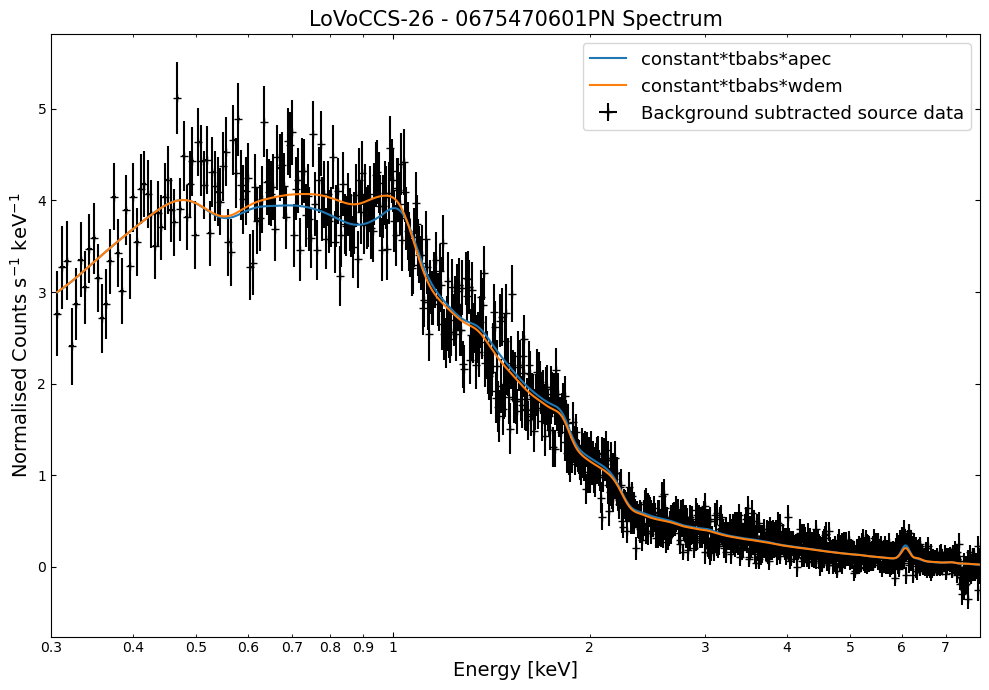

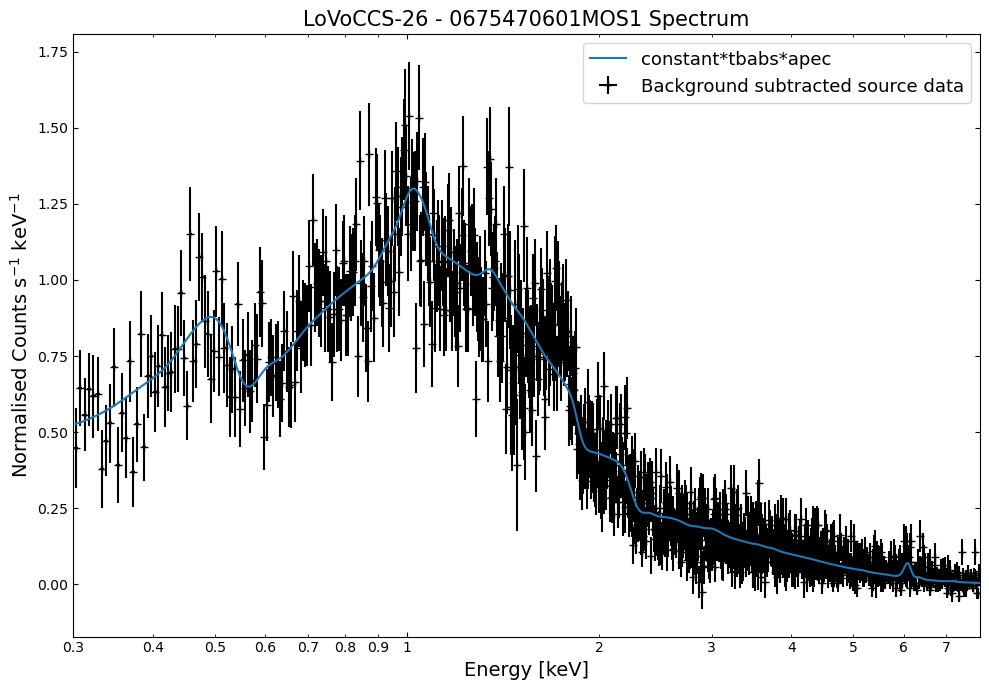

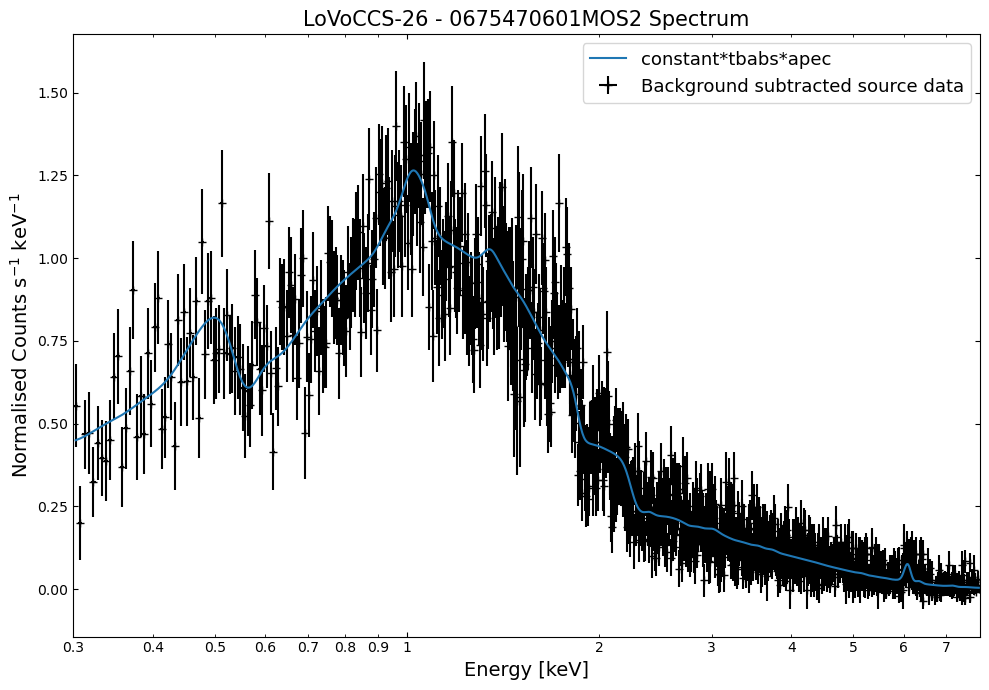

LoVoCCS-28


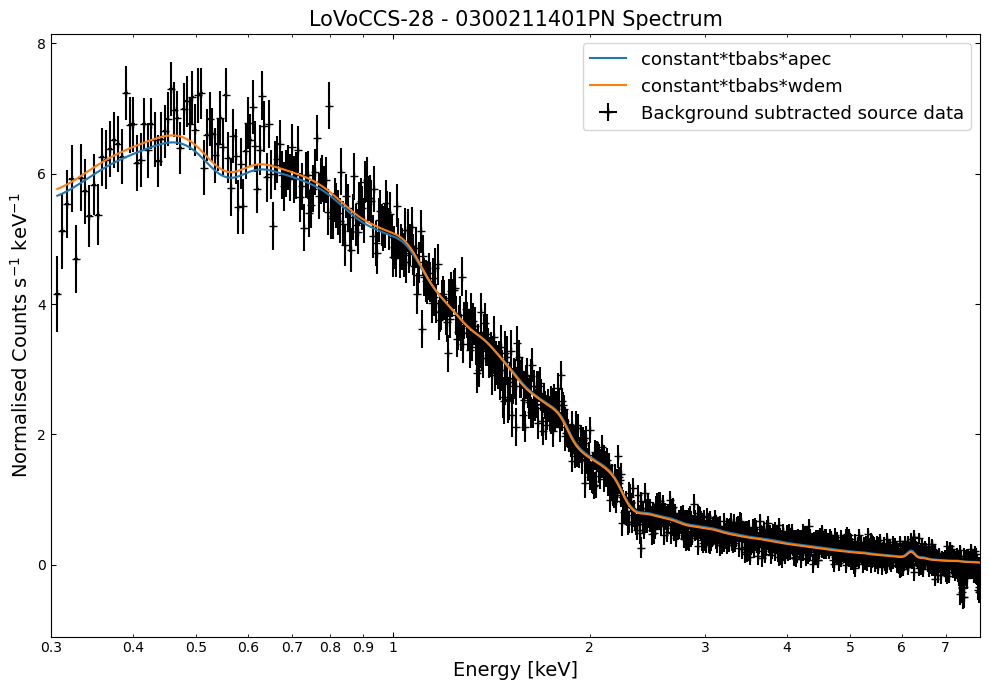

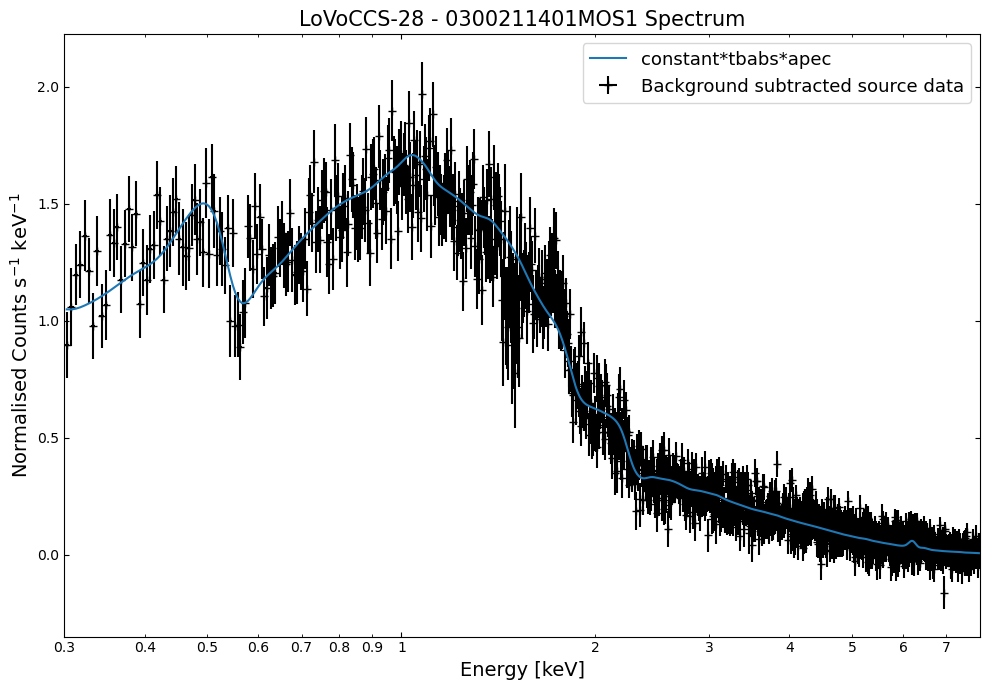

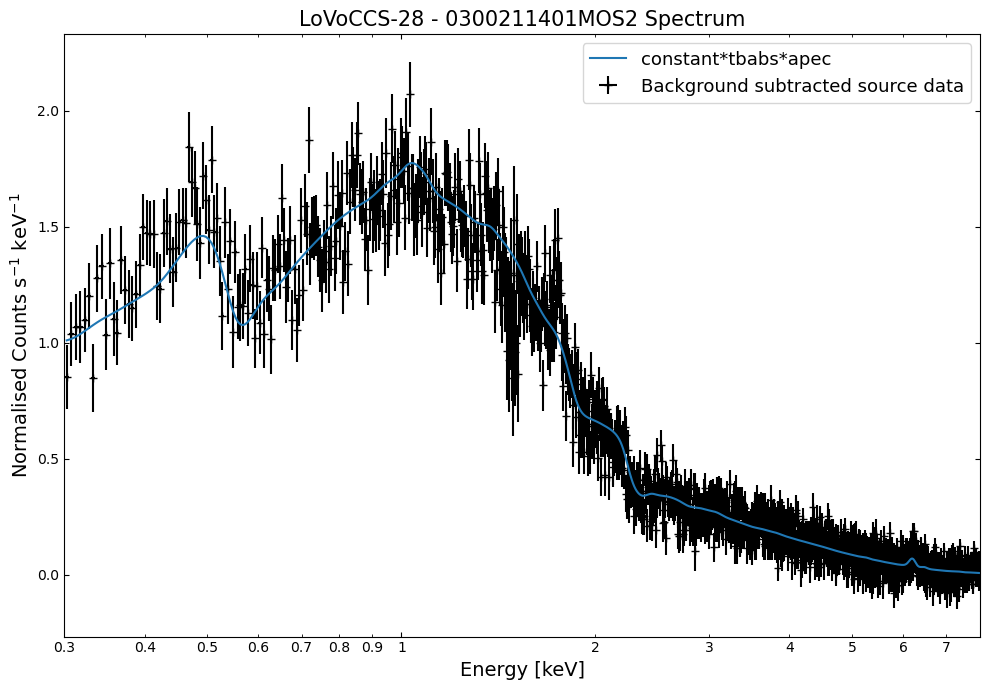

LoVoCCS-90


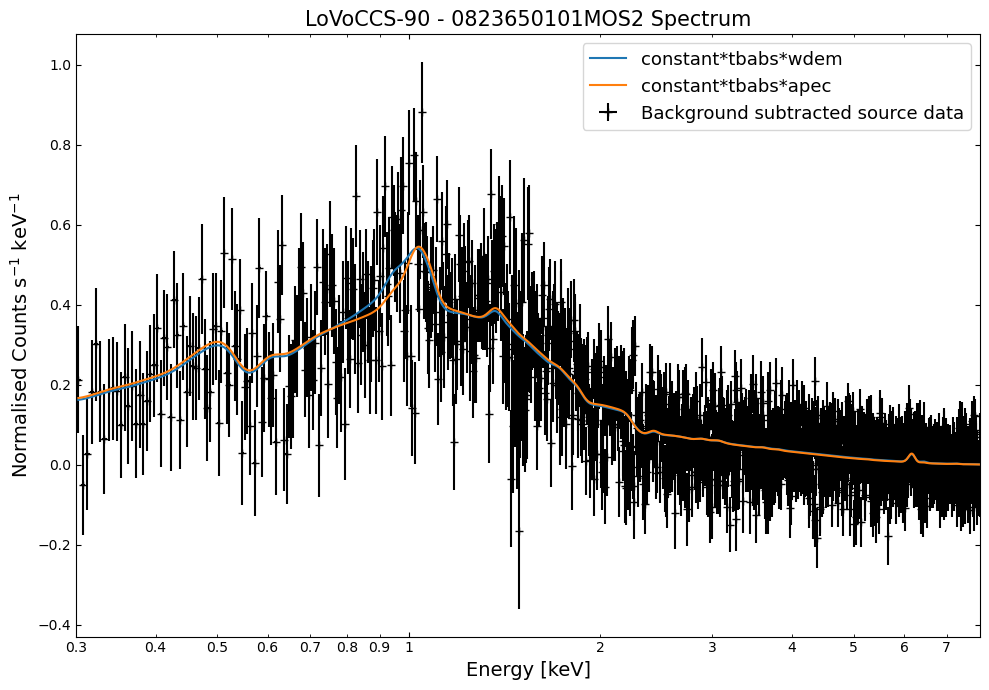

In [40]:
for src in srcs:
    rel_res_ind = np.where(wdem_res['name'].values == src.name)[0][0]
    try:
        mtxs = src.get_results(Quantity(1000, 'kpc'), 'constant*tbabs*wdem', par='Tmax')
        wdem_res.loc[rel_res_ind, ['Tmax_1000kpc', 'Tmax_1000kpc-', 'Tmax_1000kpc+']] = mtxs.round(3)
        
        print(src.name)
        sps = src.get_spectra(Quantity(1000, 'kpc'))
        if not isinstance(sps, list):
            sps = [sps]
        for sp in sps:
            sp.view()
        
        betas = src.get_results(Quantity(1000, 'kpc'), 'constant*tbabs*wdem', par='beta')
        wdem_res.loc[rel_res_ind, ['beta_1000kpc', 'beta_1000kpc-', 'beta_1000kpc+']] = betas.round(3)
        
        inv_sls = src.get_results(Quantity(1000, 'kpc'), 'constant*tbabs*wdem', par='inv_slope')
        wdem_res.loc[rel_res_ind, ['invsl_1000kpc', 'invsl_1000kpc-', 'invsl_1000kpc+']] = inv_sls.round(3)
        
        mets = src.get_results(Quantity(1000, 'kpc'), 'constant*tbabs*wdem', par='abundanc')
        wdem_res.loc[rel_res_ind, ['met_1000kpc', 'met_1000kpc-', 'met_1000kpc+']] = mets.round(3)
        
        lx52s = src.get_luminosities(Quantity(1000, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.5, 'keV'), 
                                     hi_en=Quantity(2.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lx52_1000kpc', 'Lx52_1000kpc-', 
                                   'Lx52_1000kpc+']] = lx52s.to('10^44 erg/s').value.round(3)
        
        lxbols = src.get_luminosities(Quantity(1000, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.01, 'keV'), 
                                      hi_en=Quantity(100.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lxbol_1000kpc', 'Lxbol_1000kpc-', 
                                   'Lxbol_1000kpc+']] = lxbols.to('10^44 erg/s').value.round(3)
    except ModelNotAssociatedError:
        pass

## Saving results 

We need to actually store the results on disk for easy access later:

In [41]:
apec_res.to_csv("../../outputs/results/fixed_aperture_apec.csv", index=False)
apec_res.head(10)

,name,Tx_300kpc,Tx_300kpc-,Tx_300kpc+,met_300kpc,met_300kpc-,met_300kpc+,Lx52_300kpc,Lx52_300kpc-,Lx52_300kpc+,Lxbol_300kpc,Lxbol_300kpc-,Lxbol_300kpc+,Tx_500kpc,Tx_500kpc-,Tx_500kpc+,met_500kpc,met_500kpc-,met_500kpc+,Lx52_500kpc,Lx52_500kpc-,Lx52_500kpc+,Lxbol_500kpc,Lxbol_500kpc-,Lxbol_500kpc+,Tx_1000kpc,Tx_1000kpc-,Tx_1000kpc+,met_1000kpc,met_1000kpc-,met_1000kpc+,Lx52_1000kpc,Lx52_1000kpc-,Lx52_1000kpc+,Lxbol_1000kpc,Lxbol_1000kpc-,Lxbol_1000kpc+
0,LoVoCCS-1,6.643,0.013,0.013,0.422,0.003,0.003,4.164,0.004,0.006,15.652,0.028,0.021,6.707,0.012,0.012,0.4,0.003,0.003,5.006,0.007,0.005,18.871,0.028,0.029,6.517,0.015,0.016,0.373,0.004,0.004,5.839,0.006,0.01,21.679,0.037,0.035
1,LoVoCCS-2,7.388,0.085,0.085,0.284,0.016,0.016,1.92,0.008,0.008,7.488,0.052,0.041,7.314,0.075,0.077,0.258,0.014,0.014,2.569,0.008,0.007,9.951,0.055,0.034,7.1,0.091,0.091,0.227,0.018,0.018,3.39,0.014,0.012,12.929,0.099,0.062
2,LoVoCCS-4A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-4B,6.061,0.261,0.287,0.243,0.066,0.071,0.215,0.003,0.003,0.75,0.017,0.016,6.311,0.298,0.325,0.298,0.078,0.081,0.362,0.005,0.004,1.29,0.026,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-5,5.402,0.023,0.018,0.275,0.006,0.006,1.084,0.001,0.002,3.661,0.01,0.009,5.423,0.023,0.026,0.255,0.006,0.006,1.623,0.003,0.003,5.48,0.011,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LoVoCCS-7,6.407,0.062,0.063,0.282,0.015,0.015,1.671,0.007,0.007,6.122,0.037,0.034,6.298,0.057,0.057,0.275,0.014,0.014,2.173,0.006,0.006,7.895,0.042,0.028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LoVoCCS-9,7.902,0.048,0.048,0.225,0.01,0.01,0.831,0.005,0.005,3.315,0.029,0.024,7.666,0.04,0.042,0.221,0.008,0.008,1.386,0.007,0.008,5.457,0.038,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LoVoCCS-10,5.848,0.072,0.072,0.364,0.02,0.02,1.765,0.009,0.008,6.231,0.046,0.039,5.754,0.062,0.068,0.334,0.018,0.018,2.324,0.009,0.011,8.126,0.06,0.059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LoVoCCS-11,7.852,0.075,0.075,0.296,0.014,0.015,1.076,0.002,0.003,4.302,0.016,0.021,7.861,0.065,0.065,0.282,0.012,0.012,1.752,0.004,0.006,6.999,0.037,0.032,7.668,0.079,0.086,0.286,0.016,0.016,2.203,0.005,0.005,8.716,0.051,0.039
9,LoVoCCS-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
wdem_res.to_csv("../../outputs/results/fixed_aperture_wdem.csv", index=False)